# Анализ результатов АБ-теста

В данном задании вам нужно будет

- проанализировать АБ тест, проведенный на реальных пользователях Яндекса
- подтвердить или опровергнуть наличие изменений в пользовательском поведении между контрольной (control) и тестовой (exp) группами
- определить характер этих изменений и практическую значимость вводимого изменения
- понять, какая из пользовательских групп более всего проигрывает / выигрывает от тестируемого изменения (локализовать изменение)

In [136]:
import pandas as pd
import numpy as np
from collections import Counter
from scipy import stats
from statsmodels.stats.multitest import multipletests
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
data = pd.read_csv('static/ab_browser_test.csv', index_col=0)
print("number of lines:", data.shape[0])
data.head()

number of lines: 566134


,browser,slot,n_clicks,n_queries,n_nonclk_queries
userID,,,,,
1,Browser #2,exp,23,32,19
3,Browser #4,exp,3,4,2
5,Browser #4,exp,29,35,16
6,Browser #4,control,12,6,0
7,Browser #4,exp,54,68,30


In [141]:
exp = data[data.slot == 'exp']
control = data[data.slot == 'control']

In [67]:
exp.shape[0], control.shape[0]

(281580, 284554)

In [5]:
data.describe()

,n_clicks,n_queries,n_nonclk_queries
count,566134.000000,566134.000000,566134.000000
mean,11.431658,10.720524,4.703987
std,20.251494,16.262827,8.109958
min,0.000000,1.000000,0.000000
25%,1.000000,2.000000,1.000000
50%,4.000000,5.000000,2.000000
75%,13.000000,13.000000,6.000000
max,863.000000,665.000000,581.000000


### 1. Посчитайте, насколько в группе exp больше пользовательских кликов по сравнению с группой control в процентах от числа кликов в контрольной группе.

In [44]:
(exp.n_clicks.sum()-control.n_clicks.sum())/control.n_clicks.sum()*100

1.6135689824415809

### 2. Давайте попробуем посмотреть более внимательно на разницу между двумя группами (control и exp) относительно количества пользовательских кликов.

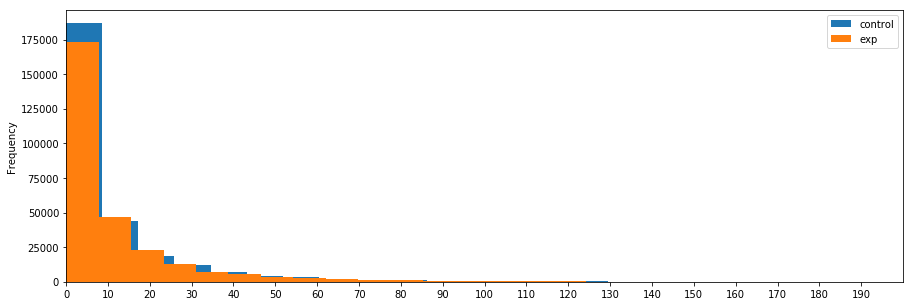

In [53]:
figsize(15,5)
data.groupby('slot').n_clicks.plot.hist(bins=100)
legend()
xlim(0,200)
xticks(range(0,200,10))
show()

In [8]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [9]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [50]:
np.random.seed(0)

ilec_median_scores = [*map(np.median, get_bootstrap_samples(exp.n_clicks.values, 100))]
clec_median_scores = [*map(np.median, get_bootstrap_samples(control.n_clicks.values, 100))]
delta_median_scores = np.array(ilec_median_scores) - np.array(clec_median_scores)

print ("95% confidence interval for the ILEC median repair time:",  stat_intervals(ilec_median_scores, 0.05))
print ("95% confidence interval for the CLEC median repair time:",  stat_intervals(clec_median_scores, 0.05))
print ("95% confidence interval for the difference between medians",  stat_intervals(delta_median_scores, 0.05))

95% confidence interval for the ILEC median repair time: [5. 5.]
95% confidence interval for the CLEC median repair time: [4. 4.]
95% confidence interval for the difference between medians [1. 1.]


In [52]:
np.random.seed(0)

ilec_mean_scores = [*map(np.mean, get_bootstrap_samples(exp.n_clicks.values, 100))]
clec_mean_scores = [*map(np.mean, get_bootstrap_samples(control.n_clicks.values, 100))]
delta_mean_scores = np.array(ilec_mean_scores) - np.array(clec_mean_scores)

print ("95% confidence interval for the ILEC mean repair time:",  stat_intervals(ilec_mean_scores, 0.05))
print ("95% confidence interval for the CLEC mean repair time:",  stat_intervals(clec_mean_scores, 0.05))
print ("95% confidence interval for the difference between means",  stat_intervals(delta_mean_scores, 0.05))

95% confidence interval for the ILEC mean repair time: [11.51021077 11.65679008]
95% confidence interval for the CLEC mean repair time: [11.21278193 11.34695708]
95% confidence interval for the difference between means [0.20696841 0.39441327]


### 3. Поскольку данных достаточно много (порядка полумиллиона уникальных пользователей), отличие в несколько процентов может быть не только практически значимым, но и значимым статистически. Последнее утверждение нуждается в дополнительной проверке.

In [66]:
stats.shapiro(exp.n_clicks)

C:\Users\creed\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.5458781719207764, 0.0)

In [69]:
np.var(control.n_clicks), np.var(exp.n_clicks)

(411.3588117554395, 408.82650090334823)

In [65]:
stats.ttest_ind(exp.n_clicks, control.n_clicks, equal_var=False)

Ttest_indResult(statistic=5.63071804102796, pvalue=1.795455499781595e-08)

In [62]:
stats.mannwhitneyu(exp.n_clicks, control.n_clicks)

MannwhitneyuResult(statistic=38940590204.0, pvalue=3.1236179006848145e-75)

### 4. Давайте постараемся понять, когда t-критерий можно применять и как это проверить на реальных данных.

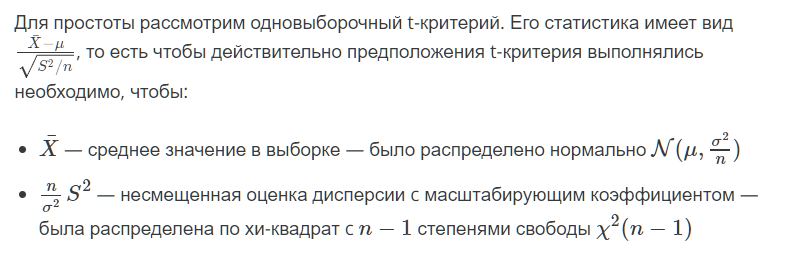

In [101]:
np.random.seed(0)
sample = get_bootstrap_samples(control.n_clicks.values, 500)
n_boot_samples = [*map(np.mean, sample)]
control_boot_chi_squared = 284554*np.var(sample, axis=1)

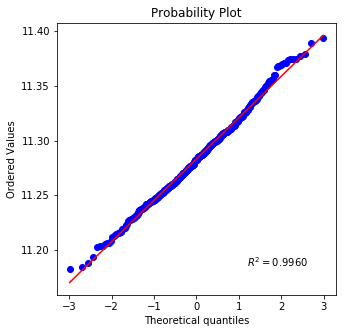

Shapiro-Wilk p-value: 0.13738656044006348


In [94]:
figsize(5,5)
stats.probplot(n_boot_samples, plot=pylab, rvalue=True)
show()
print('Shapiro-Wilk p-value:', stats.shapiro(n_boot_samples)[1])

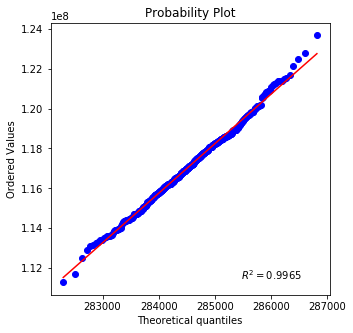

Shapiro-Wilk p-value: 0.46932366490364075


In [109]:
stats.probplot(control_boot_chi_squared, dist="chi2", sparams=(284554-1), plot=pylab, rvalue=True)
show()
print('Shapiro-Wilk p-value:', stats.shapiro(control_boot_chi_squared)[1])

### 5.  Преобразуйте данные к виду, чтобы каждому пользователю соответствовало суммарное значение его кликов. С помощью критерия Манна-Уитни проверьте гипотезу о равенстве средних. Что можно сказать о получившемся значении достигаемого уровня значимости ?

In [120]:
stats.mannwhitneyu(exp.groupby('userID')[['n_clicks']].sum().values,
                    control.groupby('userID')[['n_clicks']].sum().values, alternative='two-sided')

MannwhitneyuResult(statistic=41140868471.0, pvalue=8.694294377520879e-75)

### 6. Проверьте, для какого из браузеров наиболее сильно выражено отличие между количеством кликов в контрольной и экспериментальной группах.

In [122]:
st = []
for i in data.browser.unique():
    s, p = stats.mannwhitneyu(exp[exp.browser==i].n_clicks.values,
                               control[control.browser==i].n_clicks.values, 
                               alternative='two-sided')
    st.append([i, p])
stdf = pd.DataFrame(st, columns=['browser', 'p'])
stdf

,browser,p
0,Browser #2,0.054488
1,Browser #4,0.815212
2,Browser #14,0.000000
3,Browser #17,0.074801
4,Browser #20,0.907333
5,Browser #22,0.514811


In [137]:
stdf['reject'], stdf['p_corr'], a1, a2, = multipletests(stdf.p, method='holm')
stdf

,browser,p,reject,p_corr
0,Browser #2,0.054488,False,0.272439
1,Browser #4,0.815212,False,1.000000
2,Browser #14,0.000000,True,0.000000
3,Browser #17,0.074801,False,0.299205
4,Browser #20,0.907333,False,1.000000
5,Browser #22,0.514811,False,1.000000


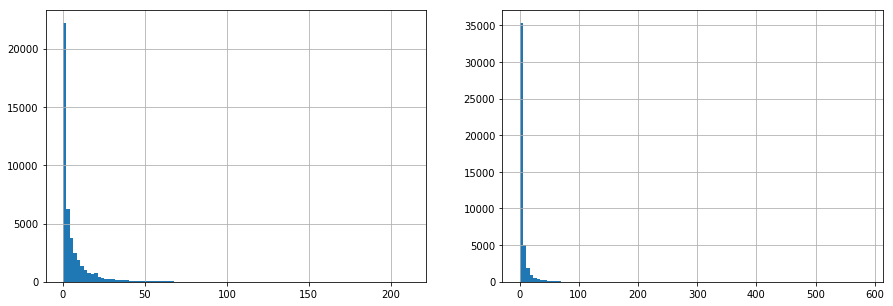

In [146]:
figsize(15,5)
subplot(1,2,1)
exp[exp.browser=='Browser #14'].n_clicks.hist(bins=100)
subplot(1,2,2)
control[control.browser=='Browser #14'].n_clicks.hist(bins=100)
show()

### 7. Для каждого браузера в каждой из двух групп (control и exp) посчитайте долю запросов, в которых пользователь не кликнул ни разу. 

In [210]:
ts = pd.DataFrame(exp.groupby('browser').apply(lambda x: sum(x.n_nonclk_queries)*100/sum(x.n_queries)), columns=['exp'])
ts = pd.concat([ts,
                pd.DataFrame(control.groupby('browser').
                             apply(lambda x: sum(x.n_nonclk_queries)*100/sum(x.n_queries)), columns=['control'])],
                axis=1)
ts['browser'] = [14,17,2,20,22,4]
ts.set_index('browser', inplace=True)
ts.sort_index()

,exp,control
browser,,
2,44.982747,45.962747
4,45.142942,46.970930
14,43.755617,57.590411
17,36.937413,36.299367
20,38.977376,40.540485
22,39.853947,40.593977


In [189]:
sum(exp.n_nonclk_queries)*100/sum(exp.n_queries), sum(control.n_nonclk_queries)*100/sum(control.n_queries)

(42.69887343806424, 45.017908420845295)